In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


Goals:

- Create periodic test data
- Forecast with LSTM

## Create periodic data for testing

In [2]:
# x range
x_max = 20000

# Angular velocities and amplitudes
omega1 = 2*np.pi / 25
Y1_max = 0.2

omega2 = 2*np.pi / 500
Y2_max = 2

omega3 = 2*np.pi / 5000
Y3_max = 10

# Gaussian noise variance
var_noise = 0.1

In [3]:
x = np.linspace(0, x_max, x_max)

In [4]:
# Generate component data
Y1 = Y1_max* np.sin(omega1*x)
Y2 = Y2_max* np.sin(omega2*x)
Y3 = Y3_max* np.sin(omega3*x)
Y_noise = np.random.normal(0,var_noise,x_max)

In [5]:
# Add components
Y = pd.DataFrame(Y1 + Y2 + Y3 + Y_noise)

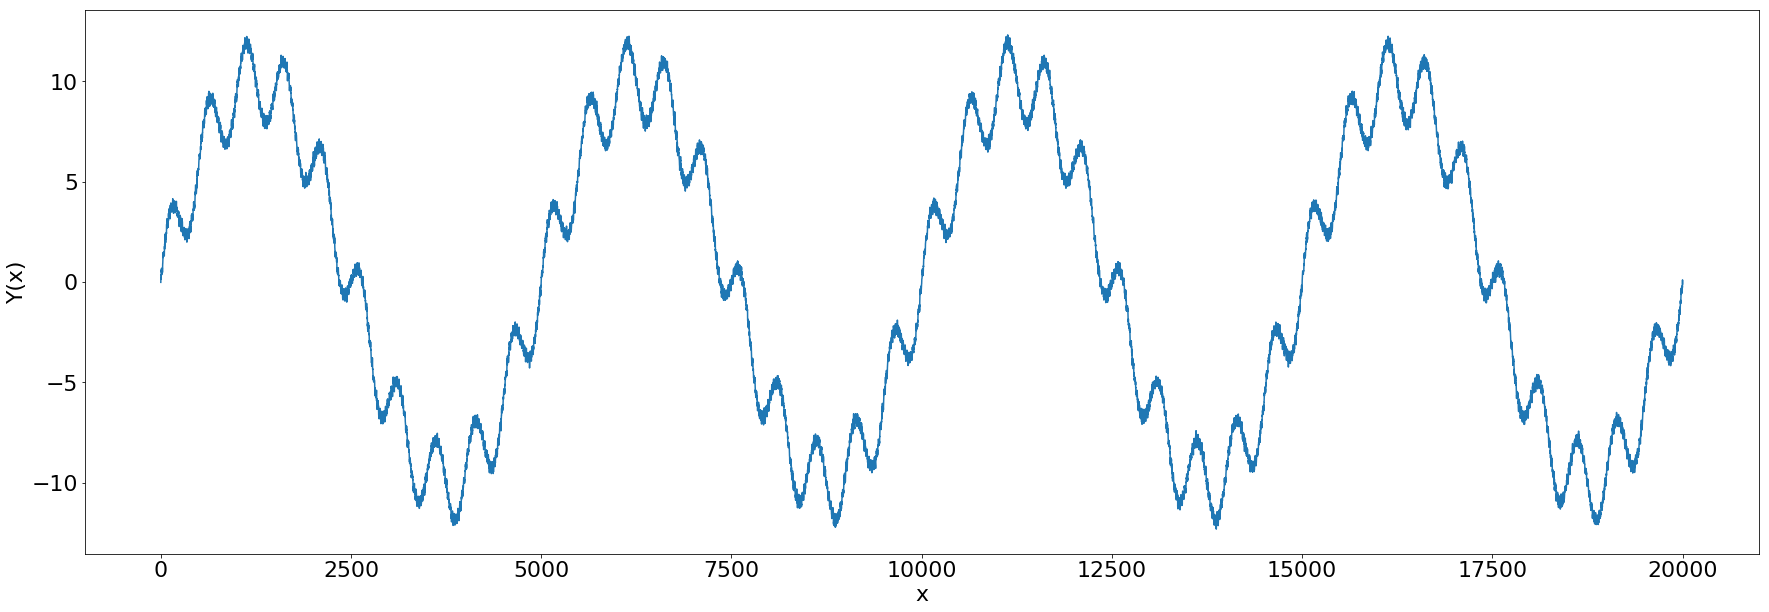

In [6]:
# Plot the data
plt.rcParams["figure.figsize"] = [30,10]
matplotlib.rcParams.update({'font.size': 22})
plt.plot(x, Y)
plt.xlabel('x')
plt.ylabel('Y(x)')
plt.axis('tight')
plt.show()

## Build an LSTM to predict the next point given a sequence of points

In [7]:
# Inspired by:
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [8]:
# Transform data to interval 0...1
scaler = MinMaxScaler(feature_range=(0, 1))
Y_scaled = pd.DataFrame(scaler.fit_transform((Y)))

In [9]:
# Split test and train
split_fraction = 0.8

Y_train = Y_scaled[0:int(split_fraction*len(Y_scaled))]
Y_test = Y_scaled[int(split_fraction*len(Y_scaled)):]

In [10]:
def transform_data_for_LSTM(Y, delta_T, T = 1):
    """ Converts times series data Y to a representation for LSTM
    with window size delta_T and forecast distance T

    Args:   Y (numpy array): (n_timepoints x 1) Vector with rows corresponding to time points (to do: allow matrix)
    
            delta_T (unsigned int): Window size of data to consider
            
            T (unsigned int): Time to look into future
    
    Return: X_lstm_in: numpy array ((n_timepoints - delta_T - T + 1) x delta_T)
            Y_lstm_out: : numpy array ((n_timepoints - delta_T - T + 1) x 1)
    """    

    X_lstm_in, Y_lstm_out = [], []
    
    for i in range(len(Y)-delta_T - T + 1):
        
        a = Y[i:(i + delta_T), 0]
        X_lstm_in.append(a)
        Y_lstm_out.append(Y[i + delta_T + T - 1, 0])
        
    return np.array(X_lstm_in), np.array(Y_lstm_out)

In [11]:
X_lstm_in, Y_lstm_out = transform_data_for_LSTM(Y_scaled.values, delta_T = 3, T = 2)

In [12]:
pd.DataFrame(X_lstm_in).head(n=6)

,0,1,2
0,0.499303,0.506481,0.509382
1,0.506481,0.509382,0.505765
2,0.509382,0.505765,0.515086
3,0.505765,0.515086,0.512774
4,0.515086,0.512774,0.519522
5,0.512774,0.519522,0.520706


This is the sequential input data for the lstm. The time progresses in columns (window size) and rows (start time). Note how each point is diagonally shifted by one in the next row.

In [13]:
pd.DataFrame(Y_lstm_out).head(n=6)

,0
0,0.515086
1,0.512774
2,0.519522
3,0.520706
4,0.526807
5,0.519496


This is the sequential output data for the lstm. Compare it to the input data. It is shifted by T (time into future).

Now let's create a dataset with a larger window size, which is hopefully useful for prediction.

In [14]:
T = 2
delta_T = 500

In [15]:
X_lstm_in_train, Y_lstm_out_train = transform_data_for_LSTM(Y_train.values, delta_T = delta_T, T = T)
X_lstm_in_test, Y_lstm_out_test = transform_data_for_LSTM(Y_test.values, delta_T = delta_T, T = T)

## Create the LSTM

In [24]:
model = Sequential()
model.add(LSTM(100, input_shape=(1, delta_T)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

Last transformation of data into a shape required for LSTM input

In [25]:
X_lstm_in_train_ = np.reshape(X_lstm_in_train, (X_lstm_in_train.shape[0], 1, X_lstm_in_train.shape[1]))
X_lstm_in_test_ = np.reshape(X_lstm_in_test, (X_lstm_in_test.shape[0], 1, X_lstm_in_test.shape[1]))

In [26]:
history = model.fit(X_lstm_in_train_, Y_lstm_out_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
 - 102s - loss: 0.0019
Epoch 2/10
 - 102s - loss: 0.0012
Epoch 3/10
 - 96s - loss: 9.4771e-04
Epoch 4/10
 - 100s - loss: 8.1252e-04
Epoch 5/10
 - 97s - loss: 7.0835e-04
Epoch 6/10
 - 95s - loss: 5.3940e-04
Epoch 7/10
 - 96s - loss: 5.4020e-04
Epoch 8/10
 - 94s - loss: 4.6562e-04
Epoch 9/10
 - 94s - loss: 3.1330e-04
Epoch 10/10
 - 93s - loss: 4.1185e-04


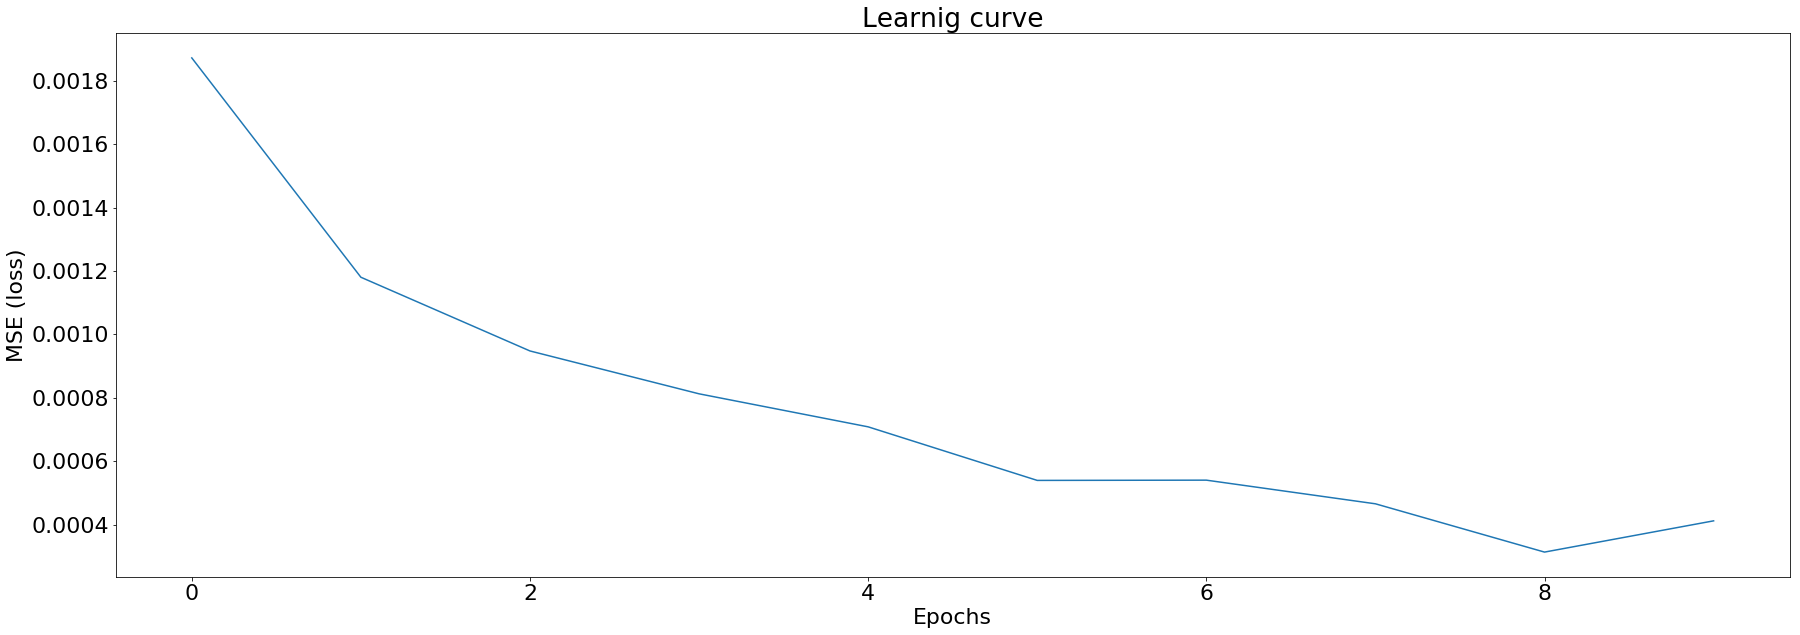

In [29]:
plt.plot(history.history['loss'])
plt.title('Learnig curve')
plt.ylabel('MSE (loss)')
plt.xlabel('Epochs')
plt.show()

I guess some more training would have helped.

In [31]:
Y_train_predict = model.predict(X_lstm_in_train_)
Y_test_predict = model.predict(X_lstm_in_test_)

Retransform data to original scale

In [32]:
Y_train_predict = scaler.inverse_transform(Y_train_predict)
Y_train_ = scaler.inverse_transform(Y_train)
Y_test_predict = scaler.inverse_transform(Y_test_predict)
Y_train = scaler.inverse_transform(Y_test)

Print the RMSE error (0 = best)

In [33]:
train_score = math.sqrt(mean_squared_error(Y_train_[0:Y_train_predict.shape[0]], Y_train_predict[:,0]))
print('Train score: %.2f RMSE' % (train_score))

test_score = math.sqrt(mean_squared_error(Y_train[0:Y_test_predict.shape[0]], Y_test_predict[:,0]))
print('Test score: %.2f RMSE' % (test_score))

Train score: 4.42 RMSE
Test score: 4.23 RMSE


That is very high, considering that our data just oscillates between -10 and 10. At least no overfitting.

Compare prediction on test to the true values

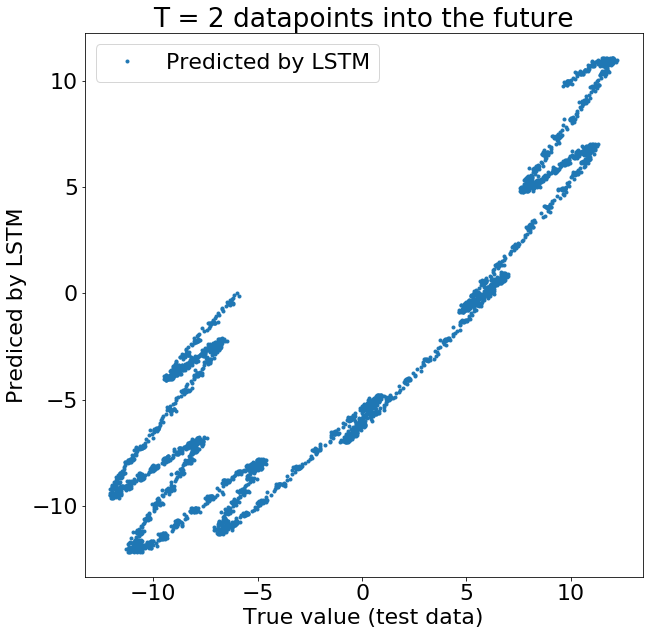

In [34]:
# Plot result
plt.rcParams["figure.figsize"] = [10,10]
matplotlib.rcParams.update({'font.size': 22})
plt.plot(Y_train[0:Y_test_predict.shape[0]], Y_test_predict[:,0], ".", label = "Predicted by LSTM")
plt.xlabel("True value (test data)")
plt.ylabel("Prediced by LSTM")
str_title = "T = %d datapoints into the future" % (T)
plt.title(str_title)
plt.axis('tight')
plt.legend()

Looks cool, although maybe not the best prediction in the world :-)